<a href="https://www.kaggle.com/code/jonathanradcliffe/4th-comp-nlp-disaster-tweets?scriptVersionId=125543591" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Introduction

To support disaster relief organisations, we've been tasked to use Natural Language Processing to build a model which predicts which Tweets are about real disasters and which ones aren't. 

This is my fourth competition and first using NLP. I'll be using https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook as a guide. 

The words in each tweet will form the features we use to model whether there is a real disaster. 
I think we will approach the following way: 

* Read in and understand the data available. 
* Identify the missing data and decide how to deal with it
* Perform feature engineer - this time around feature engineering is limited. Next time we will need to feature engineer the tweet 'text'
* Build vectors on the training dataframe using ColumnTransformer and CountVectorizer which will count the words in each tweet and turn them into data we can model
* We will do an inital assessment of a variety of models using Stratified K fold cross validation
* We will use the best peforming model and apply to the transformed test dataframe to predict the outcomes.

In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='colorblind')

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

# Read in and explore the train and test dataframes

In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
harm                     41
body%20bags              41
outbreak                 40
evacuate                 40
fear                     40
collided                 40
siren                    40
twister                  40
windstorm                40
sinkhole                 39
sunk                     39
hellfire                 39
weapon                   39
weapons                  39
famine                   39
explosion                39
whirlwind                39
earthquake               39
derailment               39
wreckage                 39
collision                39
flames                   39
wrecked                  39
oil%20spill              38
flooding                 38
deaths                   38
derailed                 38
thunder                  38
ambulance                38
drowned                  38
explode             

In [7]:
train_df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

# Let's see what's missing from both dataframes

**Let's summariese what's missing and then review how to handle the missing data**

In [8]:
missing_vals_train = pd.DataFrame(train_df.isna().sum(), columns=['Sum'])
missing_vals_train = missing_vals_train.sort_values(by = 'Sum', ascending=False)
missing_vals_train = missing_vals_train[missing_vals_train['Sum']>0]
missing_vals_train['Percent'] = missing_vals_train['Sum']/7613*100
missing_vals_train

,Sum,Percent
location,2533,33.272035
keyword,61,0.801261


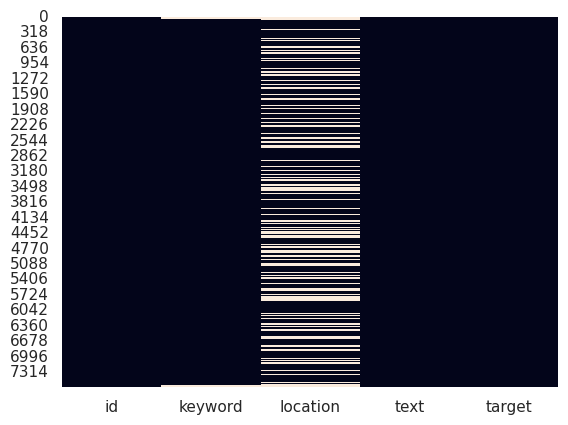

In [9]:
sns.heatmap(train_df.isnull(),cbar=False)
plt.show()

**It appears that we are missing keyword data only at the start and end of the dataframe**

**It appears that we are missing location data in blocks**

In [10]:
missing_vals_test = pd.DataFrame(test_df.isna().sum(), columns=['Sum'])
missing_vals_test = missing_vals_test.sort_values(by = 'Sum', ascending=False)
missing_vals_test = missing_vals_test[missing_vals_test['Sum']>0]
missing_vals_test['Percent'] = missing_vals_test['Sum']/3263*100
missing_vals_test

,Sum,Percent
location,1105,33.864542
keyword,26,0.796813


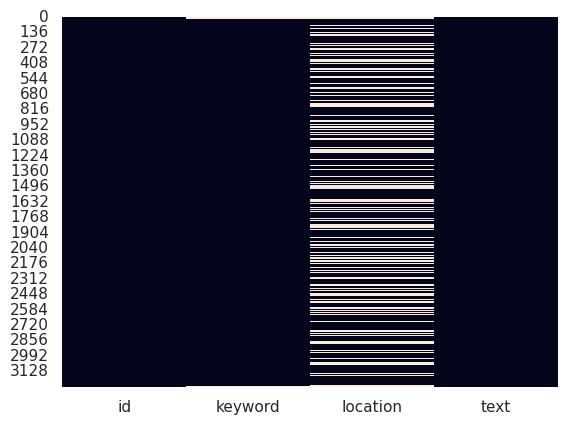

In [11]:
sns.heatmap(test_df.isnull(), cbar=False)
plt.show()

**Same observations for the test dataframe as for the train dataframe**

Let's first think about **keyword**. From the dataset description we are told: 
A keyword from that tweet (although this may be blank!)

* I'm not too sure about how the keyword is generated so I need to be careful. The first option is to remove the rows with no data. For both dataframes this is about 0.8% of the total data, which isn't too much. Unfortunately this isn't an option for the test dataframe as the submission requires the correct index. Another option would be to replace with the most frequent. Finally I don't like replacing the keyword with one of my chosing is ideal as I'm unsure how the keyword was selected. Not ideal again from a pipeline approach. I think the best approach would be to use the existing keywords as a reference and if any of these words is in the text of the tweet the one with the highest frequency should be used. For this version I'll use the first keyword found in the text of each tweet.

* It looks like keyword that are phrases have the words seperated by '%20'. I'll need to replace with a space to allow for my approach detailed above.  

In [12]:
train_df['keyword'] = train_df['keyword'].str.replace('%20', ' ')
test_df['keyword'] = test_df['keyword'].str.replace('%20', ' ')

In [13]:
refs = train_df['keyword'].tolist()
refs = [x for x in refs if str(x) != 'nan']
refs_cleaned = sorted(set(refs), key=refs.index)

In [14]:
pattern = '|'.join(refs_cleaned)

In [15]:
import re, string
def pattern_searcher(search_str:str, search_list:str):

    search_obj = re.search(search_list, search_str)
    if search_obj :
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = 'NA'
    return return_str

In [16]:
train_df['text_lower'] = train_df['text'].map(lambda x: x.lower())

test_df['text_lower'] = test_df['text'].map(lambda x: x.lower())

In [17]:
train_df.loc[(train_df['keyword'].isnull()) & (train_df['text_lower'].str.contains(pattern)),
             'keyword']= train_df['text_lower'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern))

test_df.loc[(test_df['keyword'].isnull()) & (test_df['text_lower'].str.contains(pattern)),
             'keyword']= test_df['text_lower'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern))

In [18]:
train_df.loc[train_df['keyword'].isnull(), 'keyword']='no'

test_df.loc[test_df['keyword'].isnull(), 'keyword']='no'

In [19]:
print(train_df.shape)
print(test_df.shape)

(7613, 6)
(3263, 5)


In [20]:
missing_vals_train = pd.DataFrame(train_df.isna().sum(), columns=['Sum'])
missing_vals_train = missing_vals_train.sort_values(by = 'Sum', ascending=False)
missing_vals_train = missing_vals_train[missing_vals_train['Sum']>0]
missing_vals_train['Percent'] = missing_vals_train['Sum']/7552*100
missing_vals_train

,Sum,Percent
location,2533,33.540784


In [21]:
missing_vals_test = pd.DataFrame(test_df.isna().sum(), columns=['Sum'])
missing_vals_test = missing_vals_test.sort_values(by = 'Sum', ascending=False)
missing_vals_test = missing_vals_test[missing_vals_test['Sum']>0]
missing_vals_test['Percent'] = missing_vals_test['Sum']/3237*100
missing_vals_test

,Sum,Percent
location,1105,34.136546


Let's think about **location**. From the dataset description we are told: 
The location the tweet was sent from (may also be blank)

* There is quite a lot of missing data. For each dataframe you are looking at > 33% of data missing. When the missing data is >15/20% I would be tempted to drop the feature all together. There are some locations noted in the tweets, however it is difficult to determine if that denotes a relationship between where the tweet is sent from. For this version I'll drop the column. For a future version I'll come back and see what was I can do. 

* When I come back in a future version there looks to be a good opportunity for feature engineering. We could create features for city, state, country for instance.  

In [22]:
train_df = train_df.drop(['location'], axis=1)
test_df = test_df.drop(['location'], axis=1)

# Feature Engineering

<AxesSubplot:xlabel='target', ylabel='count'>

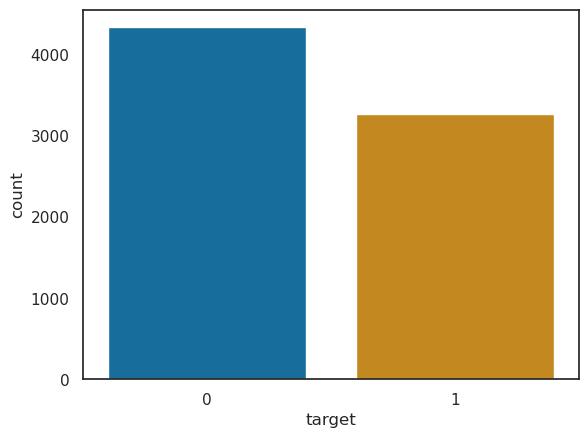

In [23]:
sns.countplot(data=train_df, x='target')

* Less observations are not classified as being related to disasters compare to those that are. 

**Let's start with keyword**

A fair bit of this is complete with the work we did above to resolve the missing data
* Let's first compare our target to keyword character length and keyword word count

In [24]:
train_df['keyword_len']=train_df['keyword'].str.len()
train_df['keyword_word']=train_df['keyword'].str.split().map(lambda x: len(x))

test_df['keyword_len']=test_df['keyword'].str.len()
test_df['keyword_word']=test_df['keyword'].str.split().map(lambda x: len(x))

<AxesSubplot:xlabel='keyword_word', ylabel='count'>

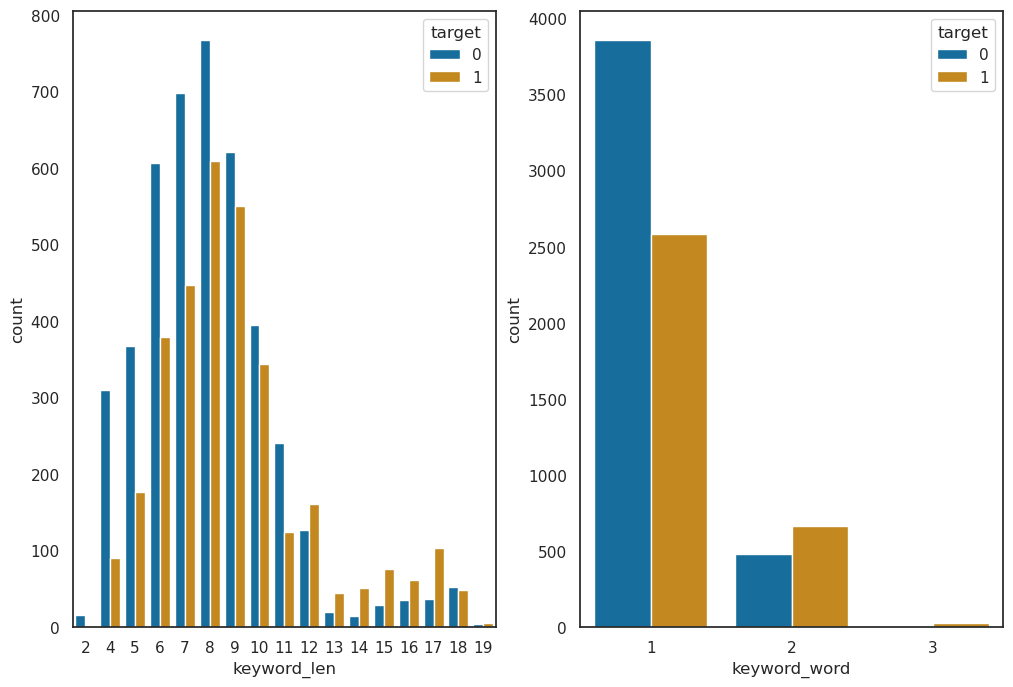

In [25]:
# Feature:  keyword
fig, ax = plt.subplots(1,2, figsize =(12, 8))
sns.countplot(data=train_df, x='keyword_len', hue='target', ax=ax[0])
sns.countplot(data=train_df, x='keyword_word', hue='target', ax=ax[1])

* Longer keyword character length increases the likelihood of disaster
* More than 1 word in keyword increases the likelihood of disaster

**Next let's look at text**

In [26]:
train_df['text'].head(50)

0     Our Deeds are the Reason of this #earthquake M...
1                Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...
5     #RockyFire Update => California Hwy. 20 closed...
6     #flood #disaster Heavy rain causes flash flood...
7     I'm on top of the hill and I can see a fire in...
8     There's an emergency evacuation happening now ...
9     I'm afraid that the tornado is coming to our a...
10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
15                                       What's up man?
16                                        I love fruits
17                                     Summer is

What a mess...lots of cleaning to do

* Let's first look at character length and word length

In [27]:
train_df['text_len']=train_df['text'].str.len()
train_df['text_word']=train_df['text'].str.split().map(lambda x: len(x))

test_df['text_len']=test_df['text'].str.len()
test_df['text_word']=test_df['text'].str.split().map(lambda x: len(x))

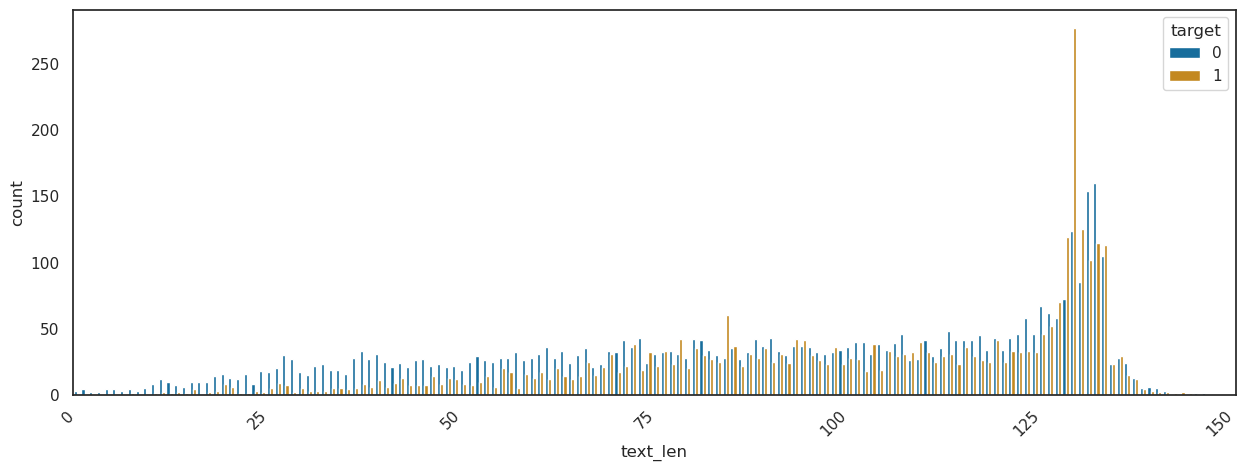

In [28]:
# Feature:  text
fig, ax = plt.subplots(figsize =(15, 5))
sns.countplot(data=train_df, x='text_len', hue='target')
labels = [0, 25, 50, 75, 100, 125, 150]
ax.set_xticks([0, 25, 50, 75, 100, 125, 150])
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.show()

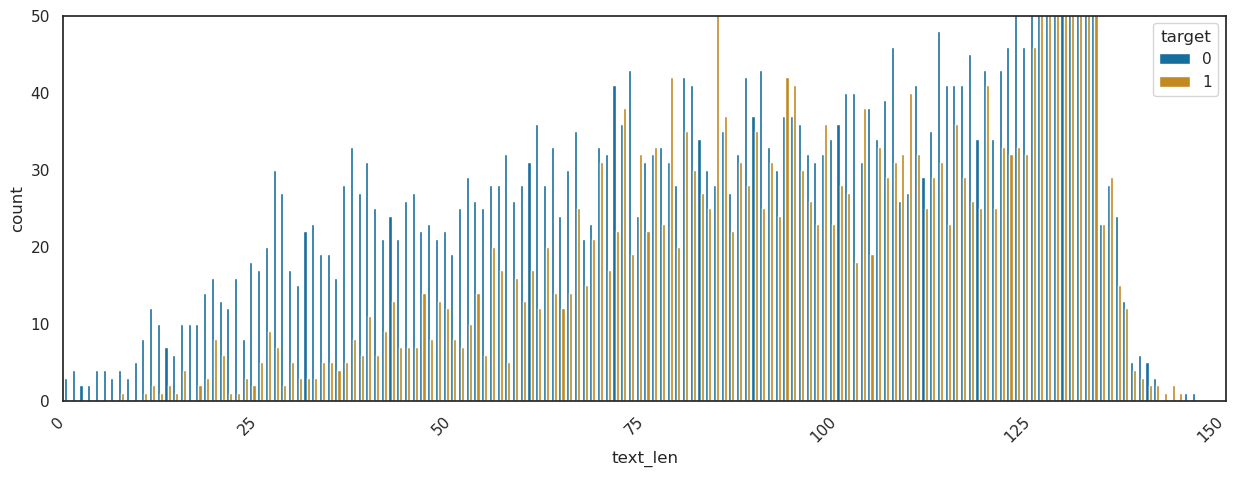

In [29]:
# Feature:  text
fig, ax = plt.subplots(figsize =(15, 5))
sns.countplot(data=train_df, x='text_len', hue='target')
labels = [0, 25, 50, 75, 100, 125, 150]
ax.set_xticks([0, 25, 50, 75, 100, 125, 150])
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylim([0, 50])
plt.show()

* Looks like the more characters in the text of the tweet then the more likely it is designated as relating to a disaster
* Disaster designation seems to pick up proportion around ~70 characters

<AxesSubplot:xlabel='text_word', ylabel='count'>

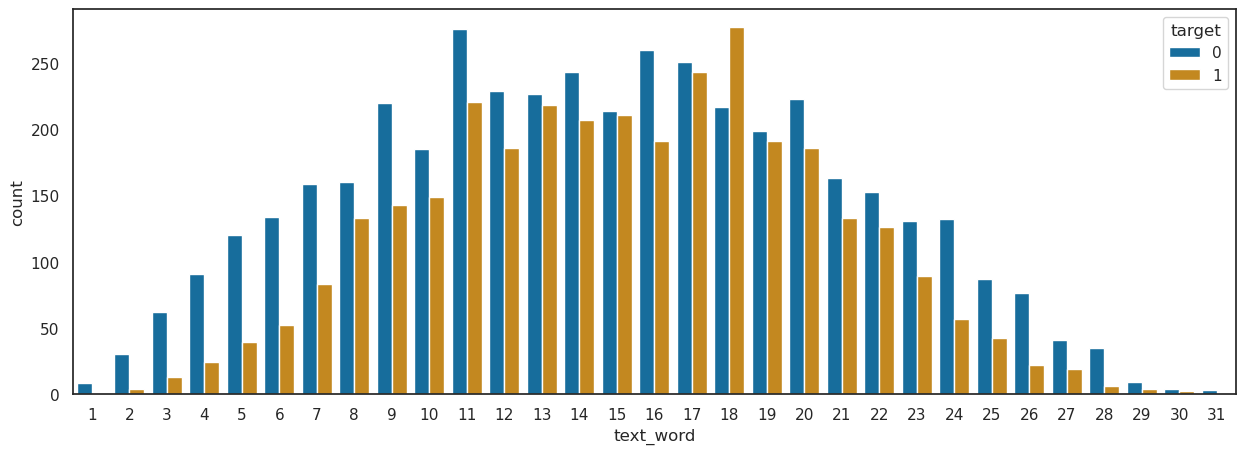

In [30]:
fig, ax = plt.subplots(figsize =(15, 5))
sns.countplot(data=train_df, x='text_word', hue='target')

* More words in text increases the likelihood of disaster.
* Disaster designation seems to pick up proportion around ~8 words

# Let's clean up text in tweet

**Many thanks to SHAHULES for your notebook**
[Amazing for data cleaning!](https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove)
* According to SHAHULES we need to clean tweet text before modelling. We will correct spelling, remove punctuations, remove html tags and emojis.  
* I'll need to come back to the character length and word count columns for text after this is complete


**Remvoing URLs**

In [31]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [32]:
train_df['text_lower']=train_df['text_lower'].apply(lambda x : remove_URL(x))

test_df['text_lower']=test_df['text_lower'].apply(lambda x : remove_URL(x))

**Remove HTML tags**

In [33]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [34]:
train_df['text_lower']=train_df['text_lower'].apply(lambda x : remove_html(x))

test_df['text_lower']=test_df['text_lower'].apply(lambda x : remove_html(x))

**Remove Emojis**

In [35]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [36]:
train_df['text_lower']=train_df['text_lower'].apply(lambda x: remove_emoji(x))

test_df['text_lower']=test_df['text_lower'].apply(lambda x: remove_emoji(x))

**Remove Punctuation**

In [37]:
def remove_punct(text):
    result = text.translate(str.maketrans('', '', string.punctuation))
    return result

In [38]:
train_df['text_lower']=train_df['text_lower'].apply(lambda x : remove_punct(x))

test_df['text_lower']=test_df['text_lower'].apply(lambda x : remove_punct(x))

**Correct Spelling**

In [39]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.1 MB/s eta 0:00:00


In [40]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    text1 = ' '.join(text.split())
    corrected_text = []
    for word in text.split():
        if spell.unknown(word) is True and spell.correction(word) is True:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [41]:
train_df['text_lower']=train_df['text_lower'].apply(lambda x : correct_spellings(x))

test_df['text_lower']=test_df['text_lower'].apply(lambda x : correct_spellings(x))

# Let's Vectorize! 

In [42]:
Y = train_df['target']
X = train_df[['keyword', 'text_lower']]

In [43]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([
    ('keyword_cv', CountVectorizer(), 'keyword'),
    ('text_cv', CountVectorizer(), 'text_lower')])

In [44]:
X_vectors = ct.fit_transform(X)

In [45]:
X_vectors

<7613x18028 sparse matrix of type '<class 'numpy.int64'>'
	with 106446 stored elements in Compressed Sparse Row format>

# Let's do an initial assessment of a variety of classifiers!

In [46]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_score
# 10 fold cross validatoin
kf = StratifiedKFold(n_splits=6)

In [47]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []

classifiers.append(CatBoostClassifier(random_state=random_state, verbose=False))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())

In [48]:
cv_results_accuracy = []
for classifier in classifiers :
    cv_results_accuracy.append(cross_val_score(classifier, X_vectors, y = Y, scoring = "accuracy", cv = kf, n_jobs=2))

cv_means_accuracy = []
for cv_result_accuracy in cv_results_accuracy:
    cv_means_accuracy.append(cv_result_accuracy.mean())

cv_accuracy = pd.DataFrame({"CrossValMeans Accuracy":cv_means_accuracy, "Algorithm":["CatBoost","XGB","SVC","DecisionTree",
"RandomForest","GradientBoosting","KNeighboors"]})

In [49]:
cv_accuracy

,CrossValMeans Accuracy,Algorithm
0,0.641018,CatBoost
1,0.639835,XGB
2,0.691982,SVC
3,0.634182,DecisionTree
4,0.655338,RandomForest
5,0.628664,GradientBoosting
6,0.580722,KNeighboors


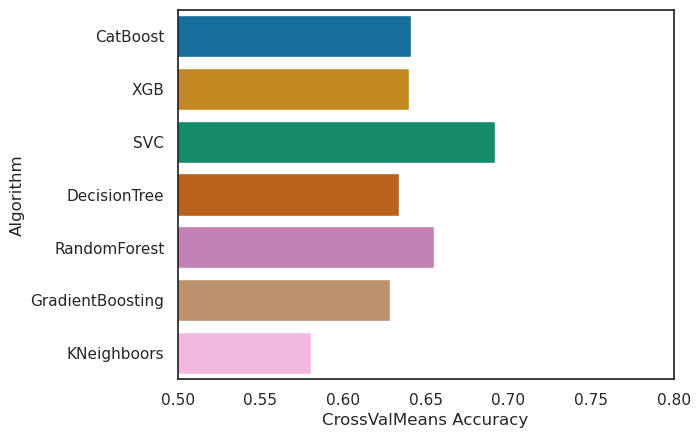

In [50]:
fig, ax = plt.subplots()
sns.barplot(x="CrossValMeans Accuracy",y="Algorithm",data = cv_accuracy, palette="colorblind", orient='h', ax=ax)
ax.set_xlim(0.5, 0.8)
plt.show()

In [51]:
cv_results_auc_roc = []
for classifier in classifiers :
    cv_results_auc_roc.append(cross_val_score(classifier, X_vectors, y = Y, scoring = "roc_auc", cv = kf, n_jobs=2))

cv_means_auc_roc = []
for cv_result_auc_roc in cv_results_auc_roc:
    cv_means_auc_roc.append(cv_result_auc_roc.mean())

cv_auc_roc = pd.DataFrame({"CrossValMeans Auc Roc":cv_means_auc_roc, "Algorithm":["CatBoost","XGB","SVC","DecisionTree",
"RandomForest","GradientBoosting", "KNeighboors"]})

In [52]:
cv_auc_roc

,CrossValMeans Auc Roc,Algorithm
0,0.681272,CatBoost
1,0.672402,XGB
2,0.736891,SVC
3,0.620881,DecisionTree
4,0.697594,RandomForest
5,0.686412,GradientBoosting
6,0.548777,KNeighboors


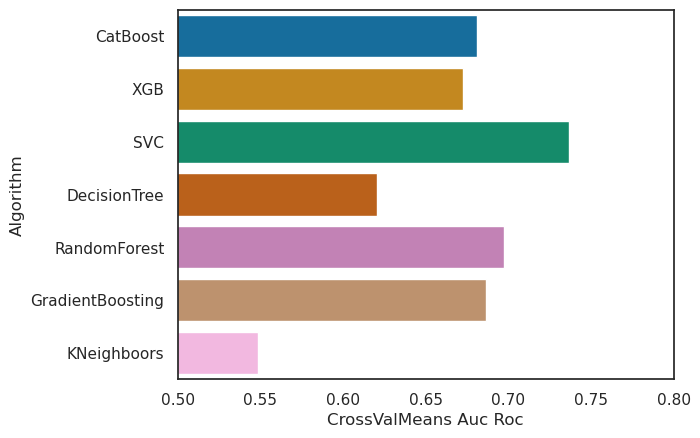

In [53]:
fig, ax = plt.subplots()
sns.barplot(x="CrossValMeans Auc Roc",y="Algorithm",data = cv_auc_roc, palette="colorblind", orient='h', ax=ax)
ax.set_xlim(0.5, 0.8)
plt.show()

# Final Model Selection

In [54]:
from sklearn.model_selection import train_test_split
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X_vectors, Y, test_size = 0.2, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (6090, 18028)
X_test : (1523, 18028)
y_train : (6090,)
y_test : (1523,)


In [55]:
classifier = SVC(probability=True)

In [56]:
scores = cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kf, n_jobs=2)
scores

array([0.85298817, 0.83194128, 0.87301277, 0.87379382, 0.86793494,
       0.8479222 ])

In [57]:
classifier.fit(X_train, y = y_train)
y_test_predict = classifier.predict(X_test)
y_train_predict = classifier.predict(X_train)
prob = classifier.predict_proba(X_test)
y_test_prob = prob[:,1]

In [58]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Suggested to me that classification report and Auc_roc is best to use

# Accuracy is a good metric for a balanced dataset
result = accuracy_score(y_test, y_test_predict)
print('Accuracy is: ', result*100)

#Log loss is a cost function which tell us how different y_test_pred is from y_test (the higher LL, the larger the error)
ll = log_loss(y_test, y_test_predict)
print('Log Loss is: ', ll)

# TL: Truely predicted as positives, BR: Truely predicted as negatives, TR: Falsely predicted as negative, BL: Falsely predicted as positive
# Accuracy of confusion matrix is (TL+BR)/attributes 
# recall is Top box from confusion matrix TL / (TL+TR) true positive / total observed positives (closer to 1 the better)
# precision is left box from confusion matris TL / (TL+BL) true postives / all records predicted as positives (closer to 1 the better)
print(confusion_matrix(y_test, y_test_predict))

#F1 is accuracy
print(classification_report(y_test, y_test_predict))


#Area under ROC
fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
print('roc_auc_score: ', roc_auc_score(y_test, y_test_prob)) # the higher the better the model is

Accuracy is:  80.9586342744583
Log Loss is:  6.576688331424578
[[822  64]
 [226 411]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       886
           1       0.87      0.65      0.74       637

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.79      1523
weighted avg       0.82      0.81      0.80      1523

roc_auc_score:  0.8496559068148878


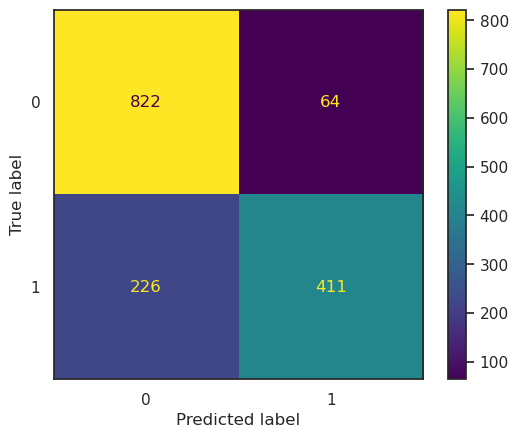

In [59]:
cm = confusion_matrix(y_test, y_test_predict, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

**Poor Precision. I'm falsely predicting tweets as indicative of a disaster**

# Predict target on tested dataframe!

In [60]:
X_test = test_df[['keyword', 'text_lower']]

In [61]:
X_test_vectors = ct.transform(X_test)

In [62]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [63]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [64]:
cond = ~sample_submission['id'].isin(test_df['id'])
sample_submission.drop(sample_submission[cond].index, inplace = True) 

In [65]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [66]:
sample_submission["target"] = classifier.predict(X_test_vectors)

In [67]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [68]:
sample_submission.to_csv("submission.csv", index=False)